In [1]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
BQ_LOCATION = 'US'
REGION = 'us-west3'

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
GCS_BUCKET = f"{PROJECT_ID}-lukes_capstone"
# !gsutil mb -l $REGION gs://$GCS_BUCKET

In [5]:
BQ_DATASET = f"{PROJECT_ID}:luke_cap_data"
# !bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

In [6]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## MAIN QUERY PIPELINE HERE

#### Look at target data, create table, filter out "bounced"?
fullVisitorid, visitId, totals, hits (target)

### Create unique id (primary key) for each session by combining fullVisitorid and visitid to create User_Session column.  Split data into tables and include User_Session as join key.

#### Create Target Data Table

In [7]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.target_data AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId,hits.hitNumber)) AS User_session,hits.eCommerceAction.action_type,if(hits.eCommerceAction.action_type = '3',1,0) AS Target 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits
);

Query is running:   0%|          |

""


In [8]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.target_data_clean AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId,hits.hitNumber)) AS User_session,hits.eCommerceAction.action_type,if(hits.eCommerceAction.action_type = '3',1,0) AS Target 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits
WHERE hits.eCommerceAction.action_type != '0'
);

Query is running:   0%|          |

""


In [9]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.target_data_event AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId,hits.hitNumber)) AS User_session,hits.eventInfo.eventAction,if(hits.eventInfo.eventAction = 'Add to cart',1,0) AS Target 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits
);

Query is running:   0%|          |

""


In [8]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE VIEW luke_cap_data.big_target_data AS (
  
# SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId)) AS User_session,hits.eCommerceAction.action_type,if(hits.eCommerceAction.action_type = '3',1,0) AS Target 
# FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
# UNNEST(hits) AS hits
# LEFT JOIN UNNEST(product) as product
# );

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,84912


In [9]:
# %%bigquery df_big_target --project $PROJECT_ID

# SELECT * 
# FROM luke_cap_data.big_target_data

In [10]:
# df_big_target.info()

In [11]:
# df_big_target["User_session"].nunique()

In [12]:
# df_big_target["Target"].value_counts()

#### Create Totals Table

In [9]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.totals AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId,hits.hitNumber)) AS User_session,totals.*,if(hits.eCommerceAction.action_type = '3',1,0) AS Target
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits 

);

Query is running:   0%|          |

""


#### Create trafficSource Table

In [10]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.trafficSource AS (
  
SELECT CONCAT(fullVisitorId,'_',visitId) AS User_session,trafficSource.*
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*` 

);

Query is running:   0%|          |

""


#### Create Device Table

In [11]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.device AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId)) AS User_session,device.*
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`

);

Query is running:   0%|          |

""


#### Create GeoNetwork Table

In [12]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.geo AS (
  
SELECT DISTINCT(CONCAT(fullVisitorId,'_',visitId)) AS User_session,geoNetwork.*
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`

);

Query is running:   0%|          |

""


#### Create Hits Table

In [13]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.hits AS (
  
SELECT CONCAT(fullVisitorId,'_',visitId) AS User_session, hits.*, if(hits.eCommerceAction.action_type = '3',1,0) AS Target 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits
);

Query is running:   0%|          |

""


#### Create Other Table

In [14]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.other AS (
  
SELECT 
    DISTINCT(CONCAT(fullVisitorId,'_',visitId)) AS User_session,
    visitorId, visitNumber, visitStartTime, customDimensions.index AS cusDim_index,
    customDimensions.value AS cusDim_value,date, userId, channelGrouping, socialEngagementType
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(customDimensions) AS customDimensions
);

Query is running:   0%|          |

""


In [15]:
%%bigquery df_target --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.target_data

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
%%bigquery df_target_clean --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.target_data_clean

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
%%bigquery df_totals --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.totals

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
%%bigquery df_trafficSource --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.trafficSource

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
%%bigquery df_device --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.device

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
%%bigquery df_geo --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.geo

Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
%%bigquery df_hits --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.hits

Query is running:   0%|          |

Downloading:   0%|          |

In [22]:
%%bigquery df_other --project $PROJECT_ID

SELECT * 
FROM luke_cap_data.other

Query is running:   0%|          |

Downloading:   0%|          |

## SEND DATA TO CSV FOR STORAGE

In [28]:
# import os
# cwd = os.getcwd()
# path = cwd + "/df_target"
# df_target.to_csv(path)

In [29]:
# path = cwd + "/df_totals"
# df_totals.to_csv(path)

In [30]:
# path = cwd + "/df_trafficSource"
# df_trafficSource.to_csv(path)

In [31]:
# path = cwd + "/df_device"
# df_device.to_csv(path)

In [32]:
# path = cwd + "/df_geo"
# df_geo.to_csv(path)

In [33]:
# path = cwd + "/df_hits"
# df_hits.to_csv(path)

In [34]:
# path = cwd + "/df_other"
# df_other.to_csv(path)

### EXPLORE TARGET DATA

In [23]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   User_session  270285 non-null  object
 1   action_type   270285 non-null  object
 2   Target        270285 non-null  Int64 
dtypes: Int64(1), object(2)
memory usage: 6.4+ MB


In [24]:
df_target["Target"].value_counts()

Target
0    262925
1      7360
Name: count, dtype: Int64

In [25]:
target_distribution = pd.DataFrame(df_target["action_type"].value_counts()).reset_index()
target_distribution

,action_type,count
0,0,207912
1,1,25966
2,2,21489
3,3,7360
4,5,5253
5,6,1483
6,4,822


In [26]:
# Value Counts by Percentage
target_distribution = pd.DataFrame(df_target["action_type"].value_counts()).reset_index()
target_distribution["Percent"] = target_distribution["count"]*100/target_distribution["count"].sum()
target_distribution

,action_type,count,Percent
0,0,207912,76.923248
1,1,25966,9.606896
2,2,21489,7.950497
3,3,7360,2.723052
4,5,5253,1.943504
5,6,1483,0.548680
6,4,822,0.304123


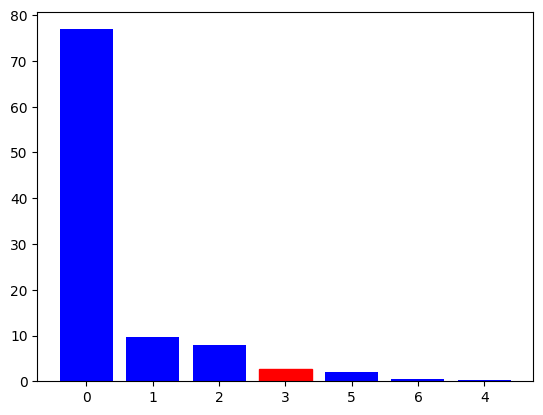

In [27]:
# Highlight Target = '3' (Add_to_cart)
index_to_highlight = 3  
# Make other bars blue
bars = plt.bar(target_distribution["action_type"], target_distribution["Percent"],color='blue')
# Change "Add_to_cart" to red
bars[index_to_highlight].set_color('red')  
plt.show()

#### Label Values
- 0: Unknown
- 1: Product_lists Clickthrough
- 2: Product detail views
- 3: ADD TO CART (Target, shown in red)
- 4: Remove product from cart
- 5: Check out
- 6: Completed Purchase

#### There are predominantly null values for the target class, so we will remove these

In [28]:
df_target_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62373 entries, 0 to 62372
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_session  62373 non-null  object
 1   action_type   62373 non-null  object
 2   Target        62373 non-null  Int64 
dtypes: Int64(1), object(2)
memory usage: 1.5+ MB


In [29]:
# Value Counts by Percentage
target_clean = pd.DataFrame(df_target_clean["action_type"].value_counts()).reset_index()
target_clean["Percent"] = target_clean["count"]*100/target_clean["count"].sum()
target_clean

,action_type,count,Percent
0,1,25966,41.630193
1,2,21489,34.452407
2,3,7360,11.799978
3,5,5253,8.421913
4,6,1483,2.377631
5,4,822,1.317878


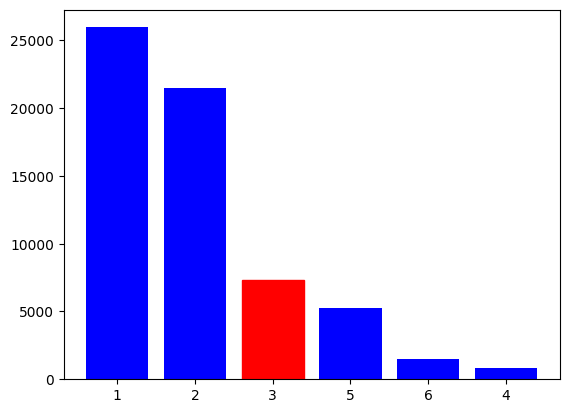

In [30]:
# Highlight Target = '3' (Add_to_cart)
index_to_highlight = 2  
# Make other bars blue
bars = plt.bar(target_clean["action_type"], target_clean["count"],color='blue')
# Change "Add_to_cart" to red
bars[index_to_highlight].set_color('red')  
plt.show()

In [32]:
target_list = list(df_target_clean.columns)
target_list

['User_session', 'action_type', 'Target']

### EXPLORE TOTALS DATA

In [35]:
df_totals.head(3)

,User_session,visits,hits,pageviews,timeOnSite,bounces,transactions,transactionRevenue,newVisits,screenviews,uniqueScreenviews,timeOnScreen,totalTransactionRevenue,sessionQualityDim,Target
0,3747703994981981896_14864273071,1,1,1,<NA>,1,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,0
1,092185348184314980_14864132501,1,1,1,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
2,44992025479320911_14864143671,1,1,1,<NA>,1,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,0


In [36]:
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   User_session             270285 non-null  object
 1   visits                   270285 non-null  Int64 
 2   hits                     270285 non-null  Int64 
 3   pageviews                270274 non-null  Int64 
 4   timeOnSite               238589 non-null  Int64 
 5   bounces                  31564 non-null   Int64 
 6   transactions             24035 non-null   Int64 
 7   transactionRevenue       24035 non-null   Int64 
 8   newVisits                185894 non-null  Int64 
 9   screenviews              0 non-null       Int64 
 10  uniqueScreenviews        0 non-null       Int64 
 11  timeOnScreen             0 non-null       Int64 
 12  totalTransactionRevenue  24035 non-null   Int64 
 13  sessionQualityDim        0 non-null       Int64 
 14  Target              

#### Nulls: screenviews, uniqueScreenviews, timeOnScreen,sessionQualityDim are 100% null so we will drop them.  

In [37]:
df_totals = df_totals.dropna(how='all', axis=1)

#### Transactions occur after "Add to Cart", so we will drop transactions, transactionRevenue, and totalTransactionRevenue to prevent Target Leakage.  Let's look at null values...  

In [38]:
df_totals = df_totals.drop(["transactions","transactionRevenue","totalTransactionRevenue"], axis=1)

In [39]:
for col in df_totals.columns:
    if col != "User_session":
        print(df_totals[col].value_counts())

visits
1    270285
Name: count, dtype: Int64
hits
1      30999
2      17400
3      15600
4      12272
5      11450
       ...  
107      107
105      105
90        90
85        85
70        70
Name: count, Length: 129, dtype: Int64
pageviews
1      31910
2      18351
3      17269
4      14358
5      14118
       ...  
108      121
84       109
87       100
81        91
60        80
Name: count, Length: 99, dtype: Int64
timeOnSite
17      826
15      819
10      793
16      791
21      777
       ... 
1326      2
1719      2
1228      2
1090      2
1404      2
Name: count, Length: 2169, dtype: Int64
bounces
1    31564
Name: count, dtype: Int64
newVisits
1    185894
Name: count, dtype: Int64
Target
0    262925
1      7360
Name: count, dtype: Int64


In [40]:
# This leaves us with only 6 features from df_totals, aside for User_session
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   User_session  270285 non-null  object
 1   visits        270285 non-null  Int64 
 2   hits          270285 non-null  Int64 
 3   pageviews     270274 non-null  Int64 
 4   timeOnSite    238589 non-null  Int64 
 5   bounces       31564 non-null   Int64 
 6   newVisits     185894 non-null  Int64 
 7   Target        270285 non-null  Int64 
dtypes: Int64(7), object(1)
memory usage: 18.3+ MB


#### timeOnSite has nulls but is informative so we will keep
#### bounces is either 1 or null by default, "1" means bounced
#### 

In [41]:
totals_list = list(df_totals.columns)
totals_list

['User_session',
 'visits',
 'hits',
 'pageviews',
 'timeOnSite',
 'bounces',
 'newVisits',
 'Target']

In [42]:
df_totals["bounces"].value_counts()

bounces
1    31564
Name: count, dtype: Int64

### EXPLORE TRAFFICSOURCE

In [43]:
df_trafficSource.head(3)

,User_session,referralPath,campaign,source,medium,keyword,adContent,adwordsClickInfo,isTrueDirect,campaignCode
0,4805174921230114482_1486492237,None,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",True,None
1,2351023648042503697_1486477444,None,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",True,None
2,274075099018939329_1486522353,None,(not set),dfa,cpm,None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",True,None


In [44]:
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_session      62192 non-null  object 
 1   referralPath      17686 non-null  object 
 2   campaign          62192 non-null  object 
 3   source            62192 non-null  object 
 4   medium            62192 non-null  object 
 5   keyword           20093 non-null  object 
 6   adContent         1560 non-null   object 
 7   adwordsClickInfo  62192 non-null  object 
 8   isTrueDirect      19786 non-null  boolean
 9   campaignCode      0 non-null      object 
dtypes: boolean(1), object(9)
memory usage: 4.4+ MB


#### adwordsClickInfo is nested so we have to look further

In [45]:
df_trafficSource["adwordsClickInfo"][0]

{'campaignId': None,
 'adGroupId': None,
 'creativeId': None,
 'criteriaId': None,
 'page': None,
 'slot': None,
 'criteriaParameters': 'not available in demo dataset',
 'gclId': None,
 'customerId': None,
 'adNetworkType': None,
 'targetingCriteria': None,
 'isVideoAd': None}

In [46]:
%%bigquery df_adwords --project $PROJECT_ID

SELECT adwordsClickinfo.* 
FROM luke_cap_data.trafficSource

Query is running:   0%|          |

Downloading:   0%|          |

In [47]:
df_adwords.head(3)

,campaignId,adGroupId,creativeId,criteriaId,page,slot,criteriaParameters,gclId,customerId,adNetworkType,targetingCriteria,isVideoAd
0,<NA>,<NA>,<NA>,<NA>,1,Top,not available in demo dataset,Cj0KEQiAzsvEBRDEluzk96e4rqABEiQAezEOoF_LgD0Twl...,<NA>,Google Search,None,False
1,<NA>,<NA>,<NA>,<NA>,<NA>,None,not available in demo dataset,None,<NA>,None,None,<NA>
2,<NA>,<NA>,<NA>,<NA>,<NA>,None,not available in demo dataset,None,<NA>,None,None,<NA>


In [48]:
# After dropping columns with 100% nulls
df_adwords = df_adwords.dropna(how='all',axis=1)
df_adwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   page                1550 non-null   Int64  
 1   slot                1550 non-null   object 
 2   criteriaParameters  62192 non-null  object 
 3   gclId               1550 non-null   object 
 4   adNetworkType       1550 non-null   object 
 5   targetingCriteria   88 non-null     object 
 6   isVideoAd           1550 non-null   boolean
dtypes: Int64(1), boolean(1), object(5)
memory usage: 3.0+ MB


In [49]:
for col in df_adwords.columns:
    print(col,":",df_adwords[col].value_counts())

page : page
1    1542
2       8
Name: count, dtype: Int64
slot : slot
Top    1514
RHS      36
Name: count, dtype: int64
criteriaParameters : criteriaParameters
not available in demo dataset    62192
Name: count, dtype: int64
gclId : gclId
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ    27
Cj0KEQiAtqHEBRCNrdC6rYq9_oYBEiQAejvRlydKqhjz1oz3BhBTfMjjueAO4Cx4no5mJL6u3XbzFHAaAlL-8P8HAQ    13
Cj0KEQiA0L_FBRDMmaCTw5nxm-ABEiQABn-VqYPBjHllWA_2v3yH9ygg977T-iJQptfHa4lhzyd60bkaAqAS8P8HAQ    10
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssliGTDKOC0uPw5dv8Gxwumt1uF9_yliW0eF6ch5r4twaApUq8P8HAQ     9
CjwKEAiArIDFBRCe_9DJi6Or0UcSJAAK1nFvAPkyO9c3vWDnAFK5OCr3WvpwsijDIrzw1205Ok2p7xoCEMTw_wcB       8
                                                                                              ..
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4Lcssi5kztG2LtiyPodNG0qVqv5zpiRbF5xDkz0zzD2m3k8aAp1l8P8HAQ     1
CLfVkfOKhNICFUWVfgodRSMAdA                                                        

#### Most of these nested fields contain high null values.  Since only a small percentage of rows have values for any of these nested fields the entire adwords.ClickInfo field will be dropped.

In [50]:
df_trafficSource = df_trafficSource.drop("adwordsClickInfo", axis=1)

In [51]:
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User_session  62192 non-null  object 
 1   referralPath  17686 non-null  object 
 2   campaign      62192 non-null  object 
 3   source        62192 non-null  object 
 4   medium        62192 non-null  object 
 5   keyword       20093 non-null  object 
 6   adContent     1560 non-null   object 
 7   isTrueDirect  19786 non-null  boolean
 8   campaignCode  0 non-null      object 
dtypes: boolean(1), object(8)
memory usage: 3.9+ MB


#### campaignCode completely null, so we will drop it.

In [52]:
df_trafficSource = df_trafficSource.dropna(how='all', axis=1)

In [53]:
print(df_trafficSource.shape)
df_trafficSource.isnull().sum()

(62192, 8)


User_session        0
referralPath    44506
campaign            0
source              0
medium              0
keyword         42099
adContent       60632
isTrueDirect    42406
dtype: int64

In [54]:
df_trafficSource.head(3)

,User_session,referralPath,campaign,source,medium,keyword,adContent,isTrueDirect
0,4805174921230114482_1486492237,None,(not set),(direct),(none),None,None,True
1,2351023648042503697_1486477444,None,(not set),(direct),(none),None,None,True
2,274075099018939329_1486522353,None,(not set),dfa,cpm,None,None,True


In [55]:
for col in df_trafficSource.columns:
    if col != "User_session":
        print(col,"'None':",len(df_trafficSource[df_trafficSource[col]==None]))
print('-'*75)
for col in df_trafficSource.columns:
    if col != "User_session":
        print(col,"'not set':",len(df_trafficSource[df_trafficSource[col]=='(not set)']))
print('-'*75)
for col in df_trafficSource.columns:
    if col != "User_session":
        print(col,"'<NA>':",len(df_trafficSource[df_trafficSource[col]=='<NA>']))
print('-'*75)
for col in df_trafficSource.columns:
    if col != "User_session":
        print(col,"'(none)':",len(df_trafficSource[df_trafficSource[col]=='(none)']))        

referralPath 'None': 0
campaign 'None': 0
source 'None': 0
medium 'None': 0
keyword 'None': 0
adContent 'None': 0
isTrueDirect 'None': 0
---------------------------------------------------------------------------
referralPath 'not set': 0
campaign 'not set': 59940
source 'not set': 0
medium 'not set': 0
keyword 'not set': 0
adContent 'not set': 0
isTrueDirect 'not set': 0
---------------------------------------------------------------------------
referralPath '<NA>': 0
campaign '<NA>': 0
source '<NA>': 0
medium '<NA>': 0
keyword '<NA>': 0
adContent '<NA>': 0
isTrueDirect '<NA>': 0
---------------------------------------------------------------------------
referralPath '(none)': 0
campaign '(none)': 0
source '(none)': 0
medium '(none)': 26549
keyword '(none)': 0
adContent '(none)': 0
isTrueDirect '(none)': 0


#### Because 'campaign' is 'not set' for almost all rows we will drop it and also "adContent" because is almost all null.

In [56]:
df_trafficSource = df_trafficSource.drop(["campaign", "adContent"], axis=1)

In [57]:
df_trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User_session  62192 non-null  object 
 1   referralPath  17686 non-null  object 
 2   source        62192 non-null  object 
 3   medium        62192 non-null  object 
 4   keyword       20093 non-null  object 
 5   isTrueDirect  19786 non-null  boolean
dtypes: boolean(1), object(5)
memory usage: 2.5+ MB


#### 'referralPath' and 'keyword' features are missing over 50% of their values and may be dropped later.

In [58]:
df_trafficSource["referralPath"].value_counts()

referralPath
/                                           5002
/yt/about/                                  2728
/analytics/web/                             1070
/yt/about/ru/                                928
/yt/about/es-419/                            496
                                            ... 
/pin/299911656420971465/                       1
/yt/about/eu/                                  1
/safeframe/1-0-5/html/container.html           1
/c/u/0/                                        1
/N4061/adi/com.ytsrc.indus/manufacturing       1
Name: count, Length: 283, dtype: int64

In [59]:
df_trafficSource.head(3)

,User_session,referralPath,source,medium,keyword,isTrueDirect
0,4805174921230114482_1486492237,None,(direct),(none),None,True
1,2351023648042503697_1486477444,None,(direct),(none),None,True
2,274075099018939329_1486522353,None,dfa,cpm,None,True


In [60]:
trafficSource_list = list(df_trafficSource.columns)
trafficSource_list

['User_session', 'referralPath', 'source', 'medium', 'keyword', 'isTrueDirect']

### EXPLORE DEVICE

In [61]:
df_device.head(3)

,User_session,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,javaEnabled,language,screenColors,screenResolution,deviceCategory
0,471818995011932337_1485984141,Firefox,not available in demo dataset,not available in demo dataset,Firefox OS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,<NA>,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
1,2515062163693201911_1485970928,Safari,not available in demo dataset,not available in demo dataset,Windows Phone,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,<NA>,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
2,1969919178914253329_1485975403,Opera Mini,not available in demo dataset,not available in demo dataset,Windows Phone,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,<NA>,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile


In [62]:
df_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62150 entries, 0 to 62149
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_session               62150 non-null  object 
 1   browser                    62150 non-null  object 
 2   browserVersion             62150 non-null  object 
 3   browserSize                62150 non-null  object 
 4   operatingSystem            62150 non-null  object 
 5   operatingSystemVersion     62150 non-null  object 
 6   isMobile                   62150 non-null  boolean
 7   mobileDeviceBranding       62150 non-null  object 
 8   mobileDeviceModel          62150 non-null  object 
 9   mobileInputSelector        62150 non-null  object 
 10  mobileDeviceInfo           62150 non-null  object 
 11  mobileDeviceMarketingName  62150 non-null  object 
 12  flashVersion               62150 non-null  object 
 13  javaEnabled                0 non-null      boo

#### Make a list (keep) of columns that do not have "not available in demo dataset" for every row

In [63]:
keep=[]
for col in df_device.columns:
        if len(df_device[df_device[col]=='not available in demo dataset']) != df_device.shape[0]:
            keep.append(col)
print(keep)

['User_session', 'browser', 'operatingSystem', 'isMobile', 'javaEnabled', 'deviceCategory']


#### Look at how many rows had 'not available in demo dataset' values for each column

In [64]:
for col in df_device.columns:
    if col != "User_session":
        print(col,":",len(df_device[df_device[col]=='not available in demo dataset']))

browser : 0
browserVersion : 62150
browserSize : 62150
operatingSystem : 0
operatingSystemVersion : 62150
isMobile : 0
mobileDeviceBranding : 62150
mobileDeviceModel : 62150
mobileInputSelector : 62150
mobileDeviceInfo : 62150
mobileDeviceMarketingName : 62150
flashVersion : 62150
javaEnabled : 0
language : 62150
screenColors : 62150
screenResolution : 62150
deviceCategory : 0


#### Most of these are 100% "not available in demo dataset", or null.  We will drop these.

In [65]:
df_device = df_device[keep]

In [66]:
df_device.head(3)

,User_session,browser,operatingSystem,isMobile,javaEnabled,deviceCategory
0,471818995011932337_1485984141,Firefox,Firefox OS,True,<NA>,mobile
1,2515062163693201911_1485970928,Safari,Windows Phone,True,<NA>,mobile
2,1969919178914253329_1485975403,Opera Mini,Windows Phone,True,<NA>,mobile


In [67]:
for col in df_device.columns:
    if col != "User_session":
        print(col,":",df_device[col].value_counts())

browser : browser
Chrome                      43757
Safari                       9690
Firefox                      3006
Internet Explorer            1729
Android Webview               975
Edge                          925
Opera Mini                    512
Safari (in-app)               475
Opera                         329
YaBrowser                     294
UC Browser                    179
Coc Coc                        65
Android Browser                39
Amazon Silk                    38
Mozilla Compatible Agent       27
BlackBerry                     24
Maxthon                        23
Puffin                         20
MRCHROME                       19
Nintendo Browser               13
Nokia Browser                   6
LYF_LS_4002_12                  2
osee2unifiedRelease             1
Mozilla                         1
SeaMonkey                       1
Name: count, dtype: int64
operatingSystem : operatingSystem
Windows          24253
Macintosh        14841
Android           9868
iOS

In [68]:
len(df_device["javaEnabled"]=='<NA>')

62150

#### We will drop javaEnabled as they are all null.

In [69]:
df_device = df_device.drop("javaEnabled", axis=1)
df_device.head(3)

,User_session,browser,operatingSystem,isMobile,deviceCategory
0,471818995011932337_1485984141,Firefox,Firefox OS,True,mobile
1,2515062163693201911_1485970928,Safari,Windows Phone,True,mobile
2,1969919178914253329_1485975403,Opera Mini,Windows Phone,True,mobile


In [70]:
device_list = list(df_device.columns)
device_list

['User_session', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory']

#### EXPLORE GEONETWORK

In [71]:
df_geo.head(3)

,User_session,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation
0,5670595757879027537_1488176681,Asia,Western Asia,United Arab Emirates,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,alshamil.net.ae,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,2110254820900687300_1488155222,Americas,Caribbean,Martinique,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,wanadoo.fr,not available in demo dataset,not available in demo dataset,not available in demo dataset
2,6043269937786527062_1488112760,Europe,Northern Europe,Denmark,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,tdc.net,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [72]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62152 entries, 0 to 62151
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_session     62152 non-null  object
 1   continent        62152 non-null  object
 2   subContinent     62152 non-null  object
 3   country          62152 non-null  object
 4   region           62152 non-null  object
 5   metro            62152 non-null  object
 6   city             62152 non-null  object
 7   cityId           62152 non-null  object
 8   networkDomain    62152 non-null  object
 9   latitude         62152 non-null  object
 10  longitude        62152 non-null  object
 11  networkLocation  62152 non-null  object
dtypes: object(12)
memory usage: 5.7+ MB


In [73]:
for col in df_geo.columns:
    if col != "User_session":
        print(col,"'not available':",len(df_geo[df_geo[col]=='not available in demo dataset']))
print('-'*75)
for col in df_geo.columns:
    if col != "User_session":
        print(col,"'not set':",len(df_geo[df_geo[col]=='(not set)']))

continent 'not available': 0
subContinent 'not available': 0
country 'not available': 0
region 'not available': 37857
metro 'not available': 37857
city 'not available': 37857
cityId 'not available': 62152
networkDomain 'not available': 0
latitude 'not available': 62152
longitude 'not available': 62152
networkLocation 'not available': 62152
---------------------------------------------------------------------------
continent 'not set': 70
subContinent 'not set': 70
country 'not set': 70
region 'not set': 1696
metro 'not set': 11006
city 'not set': 1875
cityId 'not set': 0
networkDomain 'not set': 17611
latitude 'not set': 0
longitude 'not set': 0
networkLocation 'not set': 0


#### We will drop cityId, latitude, longitude, networkLocation because they have 100% null values.  Keeping continent and subcontinent is redundant, so we will drop those as well.

In [74]:
df_geo = df_geo.drop(["cityId", "latitude","longitude","networkLocation","continent","subContinent"], axis=1)
df_geo.head(5)

,User_session,country,region,metro,city,networkDomain
0,5670595757879027537_1488176681,United Arab Emirates,not available in demo dataset,not available in demo dataset,not available in demo dataset,alshamil.net.ae
1,2110254820900687300_1488155222,Martinique,not available in demo dataset,not available in demo dataset,not available in demo dataset,wanadoo.fr
2,6043269937786527062_1488112760,Denmark,not available in demo dataset,not available in demo dataset,not available in demo dataset,tdc.net
3,5426664654086547893_1488143983,Azerbaijan,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown
4,3562136563765488594_1488098830,Cambodia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown


In [75]:
for col in df_geo.columns:
    print(col,";",df_geo[col].nunique())

User_session ; 62150
country ; 178
region ; 126
metro ; 42
city ; 187
networkDomain ; 5128


In [76]:
for col in df_geo.columns:
    if col != "User_session":
        print(df_geo[col].value_counts().head(20))

country
United States     26862
India              3346
United Kingdom     3180
Canada             1923
Germany            1654
Japan              1523
France             1498
Spain              1127
Russia             1096
Australia          1014
Netherlands         903
Brazil              891
Italy               891
Poland              760
Turkey              747
Taiwan              726
Sweden              663
Mexico              580
Thailand            505
Singapore           493
Name: count, dtype: int64
region
not available in demo dataset    37857
California                        7331
New York                          1780
(not set)                         1696
England                           1156
Illinois                           651
Texas                              547
Community of Madrid                495
Ile-de-France                      486
Maharashtra                        480
New South Wales                    407
Washington                         380
County Dubl

In [77]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62152 entries, 0 to 62151
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_session   62152 non-null  object
 1   country        62152 non-null  object
 2   region         62152 non-null  object
 3   metro          62152 non-null  object
 4   city           62152 non-null  object
 5   networkDomain  62152 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB


In [78]:
df_geo.head()

,User_session,country,region,metro,city,networkDomain
0,5670595757879027537_1488176681,United Arab Emirates,not available in demo dataset,not available in demo dataset,not available in demo dataset,alshamil.net.ae
1,2110254820900687300_1488155222,Martinique,not available in demo dataset,not available in demo dataset,not available in demo dataset,wanadoo.fr
2,6043269937786527062_1488112760,Denmark,not available in demo dataset,not available in demo dataset,not available in demo dataset,tdc.net
3,5426664654086547893_1488143983,Azerbaijan,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown
4,3562136563765488594_1488098830,Cambodia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown


In [79]:
df_geo["city"].value_counts()

city
not available in demo dataset    37857
Mountain View                     2635
(not set)                         1875
New York                          1780
San Francisco                     1565
                                 ...  
Makati                               6
Izmir                                6
Menlo Park                           5
Birmingham                           5
San Mateo                            3
Name: count, Length: 187, dtype: int64

In [80]:
df_geo.head(3)

,User_session,country,region,metro,city,networkDomain
0,5670595757879027537_1488176681,United Arab Emirates,not available in demo dataset,not available in demo dataset,not available in demo dataset,alshamil.net.ae
1,2110254820900687300_1488155222,Martinique,not available in demo dataset,not available in demo dataset,not available in demo dataset,wanadoo.fr
2,6043269937786527062_1488112760,Denmark,not available in demo dataset,not available in demo dataset,not available in demo dataset,tdc.net


In [81]:
geo_list = list(df_geo.columns)
geo_list

['User_session', 'country', 'region', 'metro', 'city', 'networkDomain']

#### EXPLORE HITS

In [82]:
df_hits.head(3)

,User_session,hitNumber,time,hour,minute,isSecure,isInteraction,isEntrance,isExit,referer,...,customDimensions,customMetrics,type,social,latencyTracking,sourcePropertyInfo,contentGroup,dataSource,publisher_infos,Target
0,4334381010732229366_1487466367,1,0,17,6,<NA>,True,True,<NA>,https://www.google.com/,...,[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0
1,4334381010732229366_1487466367,2,10199,17,6,<NA>,True,<NA>,<NA>,None,...,[],[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0
2,4334381010732229366_1487466367,3,58850,17,7,<NA>,True,<NA>,<NA>,None,...,[],[],EVENT,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0


In [83]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_session         270285 non-null  object 
 1   hitNumber            270285 non-null  Int64  
 2   time                 270285 non-null  Int64  
 3   hour                 270285 non-null  Int64  
 4   minute               270285 non-null  Int64  
 5   isSecure             0 non-null       boolean
 6   isInteraction        270285 non-null  boolean
 7   isEntrance           62185 non-null   boolean
 8   isExit               62185 non-null   boolean
 9   referer              66854 non-null   object 
 10  page                 270285 non-null  object 
 11  transaction          122965 non-null  object 
 12  item                 122965 non-null  object 
 13  contentInfo          0 non-null       object 
 14  appInfo              270285 non-null  object 
 15  exceptionInfo    

In [84]:
df_hits.social[0]

{'socialInteractionNetwork': None,
 'socialInteractionAction': None,
 'socialInteractions': None,
 'socialInteractionTarget': None,
 'socialNetwork': '(not set)',
 'uniqueSocialInteractions': None,
 'hasSocialSourceReferral': 'No',
 'socialInteractionNetworkAction': ' : '}

#### isInteraction is all True, so can be dropped
#### isEntrance is all True, so can be dropped
#### time, hour, and minute are redundant.  Minute is less useful than hour, will drop minute.
#### isExit is also not very informative, so will drop it.

In [85]:
df_hits = df_hits.drop(["isInteraction","isEntrance","minute","isExit"],axis=1)

#### Inspect nested columns within hits

In [86]:
%%bigquery df_custDims --project $PROJECT_ID

SELECT customDimensions.* 
FROM luke_cap_data.hits,
UNNEST(customDimensions) customDimensions

Query is running:   0%|          |

Downloading: |          |

In [87]:
df_custDims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   0 non-null      object
 1   value   0 non-null      object
dtypes: object(2)
memory usage: 124.0+ bytes


#### 100% null, so customDimensions will drop

In [88]:
%%bigquery df_custMets --project $PROJECT_ID

SELECT customMetrics.* 
FROM luke_cap_data.hits,
UNNEST(customMetrics) customMetrics

Query is running:   0%|          |

Downloading: |          |

In [89]:
df_custMets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   0 non-null      object
 1   value   0 non-null      object
dtypes: object(2)
memory usage: 124.0+ bytes


#### 100% null, so customMetrics will drop

In [90]:
df_hits = df_hits.drop(["customDimensions","customMetrics"],axis=1)

In [91]:
%%bigquery df_social --project $PROJECT_ID

SELECT social.* 
FROM luke_cap_data.hits

Query is running:   0%|          |

Downloading:   0%|          |

In [92]:
df_social.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   socialInteractionNetwork        0 non-null       object
 1   socialInteractionAction         0 non-null       object
 2   socialInteractions              0 non-null       Int64 
 3   socialInteractionTarget         0 non-null       object
 4   socialNetwork                   270285 non-null  object
 5   uniqueSocialInteractions        0 non-null       Int64 
 6   hasSocialSourceReferral         270285 non-null  object
 7   socialInteractionNetworkAction  270285 non-null  object
dtypes: Int64(2), object(6)
memory usage: 17.0+ MB


#### We will exclude all of the above with all nulls, which leaves socialNetwork, hasSocialSourceReferral, socialInteractionNetworkAction

In [93]:
hits_social = ["socialNetwork","hasSocialSourceReferral","socialInteractionNetworkAction"]

In [94]:
for col in hits_social:
    print(col,":",df_social[col].value_counts())

socialNetwork : socialNetwork
(not set)        246557
YouTube           18849
Facebook           2544
Google Groups       929
reddit              569
Google+             409
Quora               329
Twitter              95
Pinterest             2
VKontakte             2
Name: count, dtype: int64
hasSocialSourceReferral : hasSocialSourceReferral
No     246557
Yes     23728
Name: count, dtype: int64
socialInteractionNetworkAction : socialInteractionNetworkAction
 :     270285
Name: count, dtype: int64


#### socialInteractionNetworkAction is all ":" so we'll drop this as well

In [95]:
hits_social = ["socialNetwork","hasSocialSourceReferral"]

In [96]:
%%bigquery df_page --project $PROJECT_ID

SELECT page.* 
FROM luke_cap_data.hits

Query is running:   0%|          |

Downloading:   0%|          |

In [97]:
df_page.head(3)

,pagePath,hostname,pageTitle,searchKeyword,searchCategory,pagePathLevel1,pagePathLevel2,pagePathLevel3,pagePathLevel4
0,/store.html,shop.googlemerchandisestore.com,Waze | Google Merchandise Store,None,None,/store.html,,,
1,/asearch.html,shop.googlemerchandisestore.com,Store search results,None,None,/asearch.html,,,
2,/asearch.html,shop.googlemerchandisestore.com,Store search results,None,None,/asearch.html,,,


In [98]:
df_page.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   pagePath        270285 non-null  object
 1   hostname        270285 non-null  object
 2   pageTitle       270123 non-null  object
 3   searchKeyword   57 non-null      object
 4   searchCategory  58 non-null      object
 5   pagePathLevel1  270285 non-null  object
 6   pagePathLevel2  270285 non-null  object
 7   pagePathLevel3  270285 non-null  object
 8   pagePathLevel4  270285 non-null  object
dtypes: object(9)
memory usage: 18.6+ MB


In [99]:
for col in df_page.columns:
    print(col,":",df_page[col].value_counts())

pagePath : pagePath
/home                                                                                   62931
/google+redesign/shop+by+brand/youtube                                                  17122
/basket.html                                                                            15831
/google+redesign/apparel/men++s/men++s+t+shirts                                          8102
/signin.html                                                                             6683
                                                                                        ...  
/google+redesign/apparel/men+s+t+shirts/google+mens+short+sleeve+hero+tee+xl+bla.axd        1
/google+redesign/apparel/mans+performance+wear                                              1
/google+redesign/apparel/men+s+google+performance+polo+gb+xl.axd                            1
/google+redesign/apparel/men+s+t+shirts/google+mens+skater+tee+md+g.axd                     1
/google+redesign/apparel/men+s+google+pe

#### Most of these fields contain long, complex string data and have high dimensionality, or are largely null.  For simplicity the page category will be excluded.

In [100]:
%%bigquery df_product --project $PROJECT_ID

SELECT product.* 
FROM luke_cap_data.hits
LEFT JOIN UNNEST(product) AS product

Query is running:   0%|          |

Downloading:   0%|          |

In [101]:
df_product.head(3)

,productSKU,v2ProductName,v2ProductCategory,productVariant,productBrand,productRevenue,localProductRevenue,productPrice,localProductPrice,productQuantity,productRefundAmount,localProductRefundAmount,isImpression,isClick,customDimensions,customMetrics,productListName,productListPosition
0,GGOEAHPA004110,Android Wool Heather Cap Heather/Black,Home/Shop by Brand/Android/,(not set),(not set),<NA>,<NA>,24990000,24990000,<NA>,<NA>,<NA>,True,<NA>,[],[],Category,1
1,GGOEA0CH077599,Android Hard Cover Journal,Home/Shop by Brand/Android/,(not set),(not set),<NA>,<NA>,14990000,14990000,<NA>,<NA>,<NA>,True,<NA>,[],[],Category,6
2,GGOEAFKQ020599,Android Sticker Sheet Ultra Removable,Home/Shop by Brand/Android/,(not set),(not set),<NA>,<NA>,2990000,2990000,<NA>,<NA>,<NA>,True,<NA>,[],[],Category,12


In [102]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177272 entries, 0 to 1177271
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   productSKU                1075169 non-null  object 
 1   v2ProductName             1075169 non-null  object 
 2   v2ProductCategory         1075169 non-null  object 
 3   productVariant            1075169 non-null  object 
 4   productBrand              1075169 non-null  object 
 5   productRevenue            2060 non-null     Int64  
 6   localProductRevenue       2060 non-null     Int64  
 7   productPrice              1075169 non-null  Int64  
 8   localProductPrice         1075169 non-null  Int64  
 9   productQuantity           14318 non-null    Int64  
 10  productRefundAmount       0 non-null        Int64  
 11  localProductRefundAmount  0 non-null        Int64  
 12  isImpression              1002547 non-null  boolean
 13  isClick                   2

In [103]:
df_product["v2ProductCategory"].value_counts()

v2ProductCategory
Home/Shop by Brand/YouTube/            171886
Home/Apparel/Men's/Men's-T-Shirts/      75693
(not set)                               66690
Home/Shop by Brand/Google/              62445
Home/Apparel/Men's/Men's-Outerwear/     57167
                                        ...  
Notebooks & Journals                       47
Housewares                                 35
Bottles/                                   33
More Bags                                  32
Android                                    15
Name: count, Length: 65, dtype: int64

#### v2ProductCategory will be kept as many others seem redundant

#### transaction field will be dropped as it occurs after "add to cart", this will prevent target leakage.

In [104]:
df_hits = df_hits.drop(["page","transaction"],axis=1)

#### Now look at hits.item

In [105]:
%%bigquery df_promo --project $PROJECT_ID

SELECT promo.* 
FROM luke_cap_data.hits
LEFT JOIN UNNEST(hits.promotion) as promo

Query is running:   0%|          |

Downloading:   0%|          |

In [106]:
df_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588277 entries, 0 to 588276
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   promoId        357743 non-null  object
 1   promoName      357743 non-null  object
 2   promoCreative  357743 non-null  object
 3   promoPosition  357743 non-null  object
dtypes: object(4)
memory usage: 18.0+ MB


In [124]:
df_promo["promoId"].value_counts()

promoId
YouTube Brand Row 7-2          39750
Android Brand Row 7-3          39750
Apparel Row 1                  39749
Backpacks Row 2 Combo          39749
Mens T-Shirts Row 3-1          39749
Womens T-Shirts Row 3-2        39749
Office Row 5 Color Combo       39749
Drinkware Row 4 Color Combo    39749
Google Brand Row 7-1           39749
Name: count, dtype: int64

In [125]:
df_promo["promoName"].value_counts()

promoName
YouTube Brand      39750
Andriod Brand      39750
Apparel            39749
Backpacks          39749
Mens T-Shirts      39749
Womens T-Shirts    39749
Office             39749
Drinkware          39749
Google Brand       39749
Name: count, dtype: int64

In [126]:
df_promo["promoCreative"].value_counts()

promoCreative
home_lower_youtube_500.jpg      39750
home_lower_android_500.jpg      39750
home_main_link_apparel.jpg      39749
home_bags_google_2.jpg          39749
mens-tshirts.jpg                39749
womens-tshirts.jpg              39749
green_row_link_to_office.jpg    39749
red_row_hydrate.jpg             39749
home_lower_google_500.jpg       39749
Name: count, dtype: int64

In [127]:
df_promo["promoPosition"].value_counts()

promoPosition
Brand Row 7-2        39750
Brand Row 7-3        39750
Row 1                39749
Row 2 Combo          39749
Row 3-1              39749
Row 3-2              39749
Row 5 Color Combo    39749
Row 4 Color Combo    39749
Brand Row 7-1        39749
Name: count, dtype: int64

#### Keep promo name as some of these seem redundant

In [110]:
%%bigquery df_item --project $PROJECT_ID

SELECT item.* 
FROM luke_cap_data.hits

Query is running:   0%|          |

Downloading:   0%|          |

In [111]:
df_item.head(3)

,transactionId,productName,productCategory,productSku,itemQuantity,itemRevenue,currencyCode,localItemRevenue
0,None,None,None,None,<NA>,<NA>,None,<NA>
1,None,None,None,None,<NA>,<NA>,None,<NA>
2,None,None,None,None,<NA>,<NA>,USD,<NA>


In [112]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   transactionId     1483 non-null    object
 1   productName       0 non-null       object
 2   productCategory   0 non-null       object
 3   productSku        0 non-null       object
 4   itemQuantity      0 non-null       Int64 
 5   itemRevenue       0 non-null       Int64 
 6   currencyCode      122965 non-null  object
 7   localItemRevenue  0 non-null       Int64 
dtypes: Int64(3), object(5)
memory usage: 17.3+ MB


In [117]:
df_item = df_item.dropna(how='all',axis=1)
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   transactionId  1483 non-null    object
 1   currencyCode   122965 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


#### transaction id and currency code are also describing a purchased item, so item will be dropped to prevent target leakage.

In [118]:
df_hits = df_hits.drop("item",axis=1)

In [119]:
%%bigquery df_contentInfo --project $PROJECT_ID

SELECT contentInfo.* 
FROM luke_cap_data.hits

Query is running:   0%|          |

Downloading:   0%|          |

In [120]:
df_contentInfo.head(3)

,contentDescription
0,None
1,None
2,None


In [121]:
df_contentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   contentDescription  0 non-null      object
dtypes: object(1)
memory usage: 2.1+ MB


#### contentInfo is 100% null so will be dropped

In [122]:
df_hits = df_hits.drop("contentInfo",axis=1)
df_hits.head(3)

,User_session,hitNumber,time,hour,isSecure,referer,appInfo,exceptionInfo,eventInfo,product,...,publisher,customVariables,type,social,latencyTracking,sourcePropertyInfo,contentGroup,dataSource,publisher_infos,Target
0,4334381010732229366_1487466367,1,0,17,<NA>,https://www.google.com/,"{'name': None, 'version': None, 'id': None, 'i...","{'description': None, 'isFatal': True, 'except...",None,[],...,None,[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0
1,4334381010732229366_1487466367,2,10199,17,<NA>,None,"{'name': None, 'version': None, 'id': None, 'i...","{'description': None, 'isFatal': True, 'except...",None,[],...,None,[],PAGE,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0
2,4334381010732229366_1487466367,3,58850,17,<NA>,None,"{'name': None, 'version': None, 'id': None, 'i...","{'description': None, 'isFatal': True, 'except...","{'eventCategory': 'Contact Us', 'eventAction':...",[],...,None,[],EVENT,"{'socialInteractionNetwork': None, 'socialInte...",None,None,"{'contentGroup1': '(not set)', 'contentGroup2'...",None,[],0


In [123]:
df_hits.columns

Index(['User_session', 'hitNumber', 'time', 'hour', 'isSecure', 'referer',
       'appInfo', 'exceptionInfo', 'eventInfo', 'product', 'promotion',
       'promotionActionInfo', 'refund', 'eCommerceAction', 'experiment',
       'publisher', 'customVariables', 'type', 'social', 'latencyTracking',
       'sourcePropertyInfo', 'contentGroup', 'dataSource', 'publisher_infos',
       'Target'],
      dtype='object')

#### For now, the following will be kept from hits:


In [115]:
hits_list = ['User_session', 'hitNumber', 'time', 'hour',
       'type']
hits_social = ["socialNetwork","hasSocialSourceReferral","socialInteractionNetworkAction"]
hits_promo = ["promoName"]
hits_product = ["v2ProductCategory"]

#### EXPLORE "OTHER"

In [128]:
df_other.head(3)

,User_session,visitorId,visitNumber,visitStartTime,cusDim_index,cusDim_value,date,userId,channelGrouping,socialEngagementType
0,7313705655805460829_1486637401,<NA>,1,1486637401,4,North America,20170209,None,Paid Search,Not Socially Engaged
1,7592648761180498378_1486676911,<NA>,1,1486676911,4,North America,20170209,None,Paid Search,Not Socially Engaged
2,5797787486617061133_1486658355,<NA>,1,1486658355,4,North America,20170209,None,Paid Search,Not Socially Engaged


##### Drill down into nested features

In [129]:
df_other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51796 entries, 0 to 51795
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   User_session          51796 non-null  object
 1   visitorId             0 non-null      Int64 
 2   visitNumber           51796 non-null  Int64 
 3   visitStartTime        51796 non-null  Int64 
 4   cusDim_index          51796 non-null  Int64 
 5   cusDim_value          51796 non-null  object
 6   date                  51796 non-null  object
 7   userId                0 non-null      object
 8   channelGrouping       51796 non-null  object
 9   socialEngagementType  51796 non-null  object
dtypes: Int64(4), object(6)
memory usage: 4.1+ MB


#### First we will drop visitorId and userId as they is 100% null

In [130]:
df_other = df_other.dropna(how='all',axis=1)

In [132]:
df_other["cusDim_index"].value_counts()

cusDim_index
4    51796
Name: count, dtype: Int64

In [133]:
df_other["cusDim_value"].value_counts()

cusDim_value
North America      28805
EMEA               13653
APAC                7573
South America       1185
Central America      580
Name: count, dtype: int64

#### customDimensions doesn't contain much information and location information is already maintained elsewhere so we will drop it.

In [134]:
df_other = df_other.drop(["cusDim_index","cusDim_value"],axis=1)
df_other.head()

,User_session,visitNumber,visitStartTime,date,channelGrouping,socialEngagementType
0,7313705655805460829_1486637401,1,1486637401,20170209,Paid Search,Not Socially Engaged
1,7592648761180498378_1486676911,1,1486676911,20170209,Paid Search,Not Socially Engaged
2,5797787486617061133_1486658355,1,1486658355,20170209,Paid Search,Not Socially Engaged
3,4355131460802490782_1486627560,1,1486627560,20170209,Paid Search,Not Socially Engaged
4,6157112875945822455_1486658776,1,1486658776,20170209,Paid Search,Not Socially Engaged


In [135]:
df_other["channelGrouping"].value_counts()

channelGrouping
Organic Search    25524
Direct             8998
Social             7442
Referral           6439
Paid Search        1923
Affiliates          953
Display             517
Name: count, dtype: int64

In [136]:
df_other["socialEngagementType"].value_counts()

socialEngagementType
Not Socially Engaged    51796
Name: count, dtype: int64

#### Since there is only 1 socialEngagementType category we will drop it

In [137]:
df_other = df_other.drop("socialEngagementType", axis=1)
df_other.head()

,User_session,visitNumber,visitStartTime,date,channelGrouping
0,7313705655805460829_1486637401,1,1486637401,20170209,Paid Search
1,7592648761180498378_1486676911,1,1486676911,20170209,Paid Search
2,5797787486617061133_1486658355,1,1486658355,20170209,Paid Search
3,4355131460802490782_1486627560,1,1486627560,20170209,Paid Search
4,6157112875945822455_1486658776,1,1486658776,20170209,Paid Search


In [138]:
df_other["visitNumber"].value_counts()

visitNumber
1      38885
2       5776
3       2214
4       1211
5        737
       ...  
326        1
197        1
181        1
329        1
320        1
Name: count, Length: 169, dtype: Int64

In [139]:
other_list = list(df_other.columns)
other_list

['User_session', 'visitNumber', 'visitStartTime', 'date', 'channelGrouping']

# EVERYTHING BELOW CAN BE IGNORED FOR NOW...

#### DROP visits, bounces, newVisits

In [219]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.ML_features AS (
  
SELECT 
    DISTINCT(target.User_session) AS User_session, 
    # CAST(visits AS int) AS visits, 
    CAST(pageviews AS int) AS pageviews, 
    CAST(timeOnSite AS int) AS timeOnSite, 
    # CAST(IF(bounces='1',1,0) AS int) AS bounce, 
    # CAST(newVisits AS int) AS newVisits,
    CAST(referralPath AS string) AS referralPath, 
    source, 
    medium, 
    keyword, 
    # isTrueDirect,
    browser, 
    operatingSystem, 
    isMobile, 
    deviceCategory,
    country, 
    # IF(region='not available in demo dataset',NULL,region) AS region, 
    metro, 
    city, 
    networkDomain,
    hitNumber, 
    time, 
    hour, 
    type,
    target.Target
    
FROM luke_cap_data.target_data AS target
    INNER JOIN luke_cap_data.totals AS totals ON target.User_session = totals.User_session
    INNER JOIN luke_cap_data.trafficSource AS traffic ON target.User_session = traffic.User_session
    INNER JOIN luke_cap_data.device AS device ON target.User_session = device.User_session
    INNER JOIN luke_cap_data.geo AS geo ON target.User_session = geo.User_session
    INNER JOIN luke_cap_data.hits AS hits ON target.User_session = hits.User_session
    

);

SELECT 
  * 
FROM 
  luke_cap_data.ML_features
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,User_session,pageviews,timeOnSite,referralPath,source,medium,keyword,browser,operatingSystem,isMobile,deviceCategory,country,metro,city,networkDomain,hitNumber,time,hour,type,Target
0,3362297518035667823_1487971167,2,191,None,(direct),(none),None,Chrome,Windows,False,desktop,Poland,not available in demo dataset,not available in demo dataset,vectranet.pl,1,0,13,PAGE,0
1,7137924127061500750_1487973917,2,155,None,(direct),(none),None,Safari,iOS,True,tablet,Ukraine,not available in demo dataset,not available in demo dataset,wildpark.net,2,155357,14,PAGE,0
2,8991518919541475006_1487964317,2,12,/,(direct),(none),None,Chrome,Macintosh,False,desktop,United States,San Francisco-Oakland-San Jose CA,San Jose,(not set),2,11613,11,PAGE,0
3,6002089299065068862_1487964360,2,9,/,(direct),(none),None,Chrome,Macintosh,False,desktop,United States,Atlanta GA,Atlanta,(not set),1,0,11,PAGE,0
4,6520053255964504595_1487928964,2,30,None,(direct),(none),None,Safari,Macintosh,False,desktop,Taiwan,not available in demo dataset,not available in demo dataset,kbronet.com.tw,2,29999,1,PAGE,0


In [220]:
%%bigquery df_ML_features --project $PROJECT_ID

SELECT *
FROM luke_cap_data.ML_features

Query is running:   0%|          |

Downloading:   0%|          |

In [221]:
for col in df_ML_features.columns:
    if col != "User_session":
        print(col,":",df_ML_features[col].nunique(),df_ML_features[col].dtype)

pageviews : 99 Int64
timeOnSite : 2169 Int64
referralPath : 283 object
source : 106 object
medium : 6 object
keyword : 388 object
browser : 25 object
operatingSystem : 14 object
isMobile : 2 boolean
deviceCategory : 3 object
country : 178 object
metro : 42 object
city : 187 object
networkDomain : 5128 object
hitNumber : 278 Int64
time : 164302 Int64
hour : 24 Int64
type : 2 object
Target : 2 Int64


In [222]:
df_ML_features.shape

(353307, 20)

In [218]:
print(df_target.shape)
print(df_totals.shape)
print(df_trafficSource.shape)
print(df_device.shape)
print(df_geo.shape)
print(df_hits.shape)
print(df_other.shape)

(270285, 3)
(62192, 7)
(62192, 6)
(62192, 5)
(62192, 6)
(270285, 5)
(62192, 5)


In [211]:
270285+62192

332477

In [212]:
df_ML_features.shape

(353307, 20)

In [224]:
df_ML_features.duplicated().value_counts()

False    353307
Name: count, dtype: int64

In [213]:
df_ML_features.head()

,User_session,pageviews,timeOnSite,referralPath,source,medium,keyword,browser,operatingSystem,isMobile,deviceCategory,country,metro,city,networkDomain,hitNumber,time,hour,type,Target
0,010388923969538829_1486586065,1,<NA>,None,(direct),(none),None,Safari,iOS,True,mobile,United States,Seattle-Tacoma WA,Seattle,att.net,1,0,12,PAGE,0
1,973267985661425945_1486549039,1,<NA>,None,(direct),(none),None,Safari,Macintosh,False,desktop,Russia,not available in demo dataset,not available in demo dataset,(not set),1,0,2,PAGE,0
2,0652526355873879480_1486573261,1,<NA>,None,(direct),(none),None,Chrome,Macintosh,False,desktop,United States,not available in demo dataset,not available in demo dataset,unknown.unknown,1,0,9,PAGE,0
3,9625268878869160238_1486583531,1,<NA>,None,(direct),(none),None,Chrome,Windows,False,desktop,France,not available in demo dataset,not available in demo dataset,bbox.fr,1,0,11,PAGE,0
4,2810092680260685081_1486588469,1,<NA>,None,(direct),(none),None,Chrome,Android,True,tablet,Belgium,not available in demo dataset,not available in demo dataset,(not set),1,0,13,PAGE,0


In [225]:
# Master Feature List (for now):
print(totals_list)
print(trafficSource_list)
print(device_list)
print(geo_list)
print(hits_list)
print(target_list)
# ML_features = totals_list + trafficSource_list
# print(ML_features)

['User_session', 'visits', 'hits', 'pageviews', 'timeOnSite', 'bounces', 'newVisits']
['User_session', 'referralPath', 'source', 'medium', 'keyword', 'isTrueDirect']
['User_session', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory']
['User_session', 'country', 'region', 'metro', 'city', 'networkDomain']
['User_session', 'hitNumber', 'time', 'hour', 'type']
['User_session', 'action_type', 'Target']


In [250]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW luke_cap_data.ML_final AS (
  
 SELECT 
    DISTINCT(CONCAT(fullVisitorId,visitId,hits.hitNumber)) AS User_session,
    if(hits.eCommerceAction.action_type = '3',1,0) AS Target,
    CAST(totals.pageviews AS int) AS pageviews, 
    CAST(totals.timeOnSite AS int) AS timeOnSite, 
    # CAST(trafficSource.referralPath AS string) AS referralPath, 
    trafficSource.source AS source, 
    trafficSource.medium AS medium, 
    # IF(trafficSource.keyword="(not provided)",NULL,trafficSource.keyword) AS keyword, 
    device.browser AS browser, 
    device.operatingSystem AS os, 
    # device.isMobile AS mobile, 
    device.deviceCategory AS deviceType,
    geoNetwork.country AS country, 
    IF(geoNetwork.region='not available in demo dataset',NULL,geoNetwork.region) AS region, 
    IF(geoNetwork.metro='not available in demo dataset',NULL,geoNetwork.metro) AS metro, 
    IF(geoNetwork.city='not available in demo dataset',NULL,geoNetwork.city) AS city, 
    geoNetwork.networkDomain AS domain,
    hits.hitNumber AS hitNumber, 
    hits.time AS time, 
    hits.hour AS hour, 
    hits.type AS hitType,

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits   

);

SELECT 
  * 
FROM 
  luke_cap_data.ML_final
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,User_session,Target,pageviews,timeOnSite,source,medium,browser,os,deviceType,country,region,metro,city,domain,hitNumber,time,hour,hitType
0,157490598778988644114862007151,0,1,<NA>,(direct),(none),Chrome,iOS,mobile,United States,California,San Diego CA,San Diego,(not set),1,0,1,PAGE
1,014891827690511687714862639251,0,1,<NA>,(direct),(none),Chrome,Windows,desktop,United States,Illinois,Chicago IL,Chicago,comcast.net,1,0,19,PAGE
2,28911885475056793114862289731,0,1,<NA>,(direct),(none),Safari,iOS,tablet,United States,New York,New York NY,New York,rr.com,1,0,9,PAGE
3,233683253100876142814861972151,0,1,<NA>,(direct),(none),Safari,Macintosh,desktop,United States,California,San Francisco-Oakland-San Jose CA,Redwood City,unknown.unknown,1,0,0,PAGE
4,227010627002644223514862746391,0,1,<NA>,(direct),(none),Chrome,Windows,desktop,Serbia,None,None,None,mediaworksit.net,1,0,22,PAGE


In [251]:
%%bigquery df_ML_final --project $PROJECT_ID

SELECT 
    DISTINCT(CONCAT(fullVisitorId,visitId,hits.hitNumber)) AS User_session,
    if(hits.eCommerceAction.action_type = '3',1,0) AS Target,
    CAST(totals.pageviews AS int) AS pageviews, 
    CAST(totals.timeOnSite AS int) AS timeOnSite, 
    # CAST(trafficSource.referralPath AS string) AS referralPath, 
    trafficSource.source AS source, 
    trafficSource.medium AS medium, 
    # IF(trafficSource.keyword="(not provided)",NULL,trafficSource.keyword) AS keyword, 
    device.browser AS browser, 
    device.operatingSystem AS os, 
    # device.isMobile AS mobile, 
    device.deviceCategory AS deviceType,
    geoNetwork.country AS country, 
    IF(geoNetwork.region='not available in demo dataset',NULL,geoNetwork.region) AS region, 
    IF(geoNetwork.metro='not available in demo dataset',NULL,geoNetwork.metro) AS metro, 
    IF(geoNetwork.city='not available in demo dataset',NULL,geoNetwork.city) AS city, 
    geoNetwork.networkDomain AS domain,
    hits.hitNumber AS hitNumber, 
    hits.time AS time, 
    hits.hour AS hour, 
    hits.type AS hitType,

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits;

Query is running:   0%|          |

Downloading:   0%|          |

In [244]:
df_ML_final.shape

(270285, 19)

In [245]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [239]:
df_ML_final.head()

,User_session,action_type,Target,pageviews,timeOnSite,referralPath,source,medium,keyword,browser,os,deviceType,country,region,metro,city,domain,hitNumber,time,hour,hitType
0,492240093037459274614879013392,0,0,16,395,None,google,organic,(not provided),Safari,iOS,tablet,Canada,None,None,None,videotron.ca,2,12009,17,PAGE
1,492240093037459274614879013394,0,0,16,395,None,google,organic,(not provided),Safari,iOS,tablet,Canada,None,None,None,videotron.ca,4,38157,17,PAGE
2,492240093037459274614879013395,0,0,16,395,None,google,organic,(not provided),Safari,iOS,tablet,Canada,None,None,None,videotron.ca,5,47676,17,PAGE
3,492240093037459274614879013397,0,0,16,395,None,google,organic,(not provided),Safari,iOS,tablet,Canada,None,None,None,videotron.ca,7,97176,17,PAGE
4,492240093037459274614879013399,2,0,16,395,None,google,organic,(not provided),Safari,iOS,tablet,Canada,None,None,None,videotron.ca,9,112118,17,PAGE


In [246]:
df_ML_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270285 entries, 0 to 270284
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   User_session  270285 non-null  object
 1   action_type   270285 non-null  object
 2   Target        270285 non-null  Int64 
 3   pageviews     270274 non-null  Int64 
 4   timeOnSite    238589 non-null  Int64 
 5   source        270285 non-null  object
 6   medium        270285 non-null  object
 7   browser       270285 non-null  object
 8   os            270285 non-null  object
 9   deviceType    270285 non-null  object
 10  country       270285 non-null  object
 11  region        115810 non-null  object
 12  metro         115810 non-null  object
 13  city          115810 non-null  object
 14  domain        270285 non-null  object
 15  hitNumber     270285 non-null  Int64 
 16  time          270285 non-null  Int64 
 17  hour          270285 non-null  Int64 
 18  hitType       270285 non

In [247]:
for col in df_ML_final.columns:
    if col != "User_session":
        print(col,":",df_ML_final[col].nunique(),df_ML_final[col].dtype)

action_type : 7 object
Target : 2 Int64
pageviews : 99 Int64
timeOnSite : 2169 Int64
source : 106 object
medium : 6 object
browser : 25 object
os : 14 object
deviceType : 3 object
country : 178 object
region : 125 object
metro : 41 object
city : 186 object
domain : 5128 object
hitNumber : 278 Int64
time : 164302 Int64
hour : 24 Int64
hitType : 2 object


In [ ]:
# *** 2nd Model feature attempt ***

In [ ]:
%%bigquery df_ML_final --project $PROJECT_ID

SELECT 
    DISTINCT(CONCAT(fullVisitorId,visitId,hits.hitNumber)) AS User_session,
    if(hits.eCommerceAction.action_type = '3',1,0) AS Target,
    CAST(totals.pageviews AS int) AS pageviews, 
    CAST(totals.timeOnSite AS int) AS timeOnSite, 
    # CAST(trafficSource.referralPath AS string) AS referralPath, 
    trafficSource.source AS source, 
    trafficSource.medium AS medium, 
    # IF(trafficSource.keyword="(not provided)",NULL,trafficSource.keyword) AS keyword, 
    device.browser AS browser, 
    device.operatingSystem AS os, 
    # device.isMobile AS mobile, 
    device.deviceCategory AS deviceType,
    geoNetwork.country AS country, 
    IF(geoNetwork.region='not available in demo dataset',NULL,geoNetwork.region) AS region, 
    IF(geoNetwork.metro='not available in demo dataset',NULL,geoNetwork.metro) AS metro, 
    IF(geoNetwork.city='not available in demo dataset',NULL,geoNetwork.city) AS city, 
    geoNetwork.networkDomain AS domain,
    hits.hitNumber AS hitNumber, 
    hits.time AS time, 
    hits.hour AS hour, 
    hits.type AS hitType,

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits;

In [ ]:
%%bigquery df_Model2 --project $PROJECT_ID

SELECT 
    DISTINCT(CONCAT(fullVisitorId,visitId,hits.hitNumber)) AS User_session,
    if(hits.eCommerceAction.action_type = '3',1,0) AS Target,
    CAST(totals.pageviews AS int) AS pageviews, 
    CAST(totals.timeOnSite AS int) AS timeOnSite, 
    # CAST(trafficSource.referralPath AS string) AS referralPath, 
    trafficSource.source AS source, 
    trafficSource.medium AS medium, 
    # IF(trafficSource.keyword="(not provided)",NULL,trafficSource.keyword) AS keyword, 
    device.browser AS browser, 
    device.operatingSystem AS os, 
    # device.isMobile AS mobile, 
    device.deviceCategory AS deviceType,
    geoNetwork.country AS country, 
    IF(geoNetwork.region='not available in demo dataset',NULL,geoNetwork.region) AS region, 
    IF(geoNetwork.metro='not available in demo dataset',NULL,geoNetwork.metro) AS metro, 
    IF(geoNetwork.city='not available in demo dataset',NULL,geoNetwork.city) AS city, 
    geoNetwork.networkDomain AS domain,
    hits.hitNumber AS hitNumber, 
    hits.time AS time, 
    hits.hour AS hour, 
    hits.type AS hitType,

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201702*`, 
UNNEST(hits) AS hits;